In [1]:
import math
from matplotlib import pyplot
import numpy
from scipy.sparse import csr_matrix, coo_matrix
import scipy.sparse.linalg as splinalg

import pyibm

%matplotlib inline

In [2]:
pyplot.rc('font', family='serif', size=14)

In [3]:
pyibm.__version__

'0.1'

In [4]:
# Set configuration parameters of computational grid.
xstart, xend, nx = 0.0, 2 * numpy.pi, 100
ystart, yend, ny = 0.0, 2 * numpy.pi, 100
config = dict(x=dict(start=xstart, end=xend, num_cells=nx),
              y=dict(start=ystart, end=yend, num_cells=ny))
dx, dy = (xend - xstart) / nx, (yend - ystart) / ny
# Create staggered grids.
grid = pyibm.GridBase(config=config)  # vertex grid
gridc = pyibm.GridCellCentered(grid=grid)  # cell-centered grid
gridx = pyibm.GridFaceX(grid=grid)  # x-face centered grid
gridy = pyibm.GridFaceY(grid=grid)  # y-face centered grid
print(gridc)
print(gridx)
print(gridy)

Grid(size=10000, shape=(100, 100), gridlines=[
Gridline(start=0.0, end=6.283185307179586, size=100),
Gridline(start=0.0, end=6.283185307179586, size=100)])
Grid(size=9900, shape=(100, 99), gridlines=[
Gridline(start=0.0, end=6.283185307179586, size=99),
Gridline(start=0.0, end=6.283185307179586, size=100)])
Grid(size=9900, shape=(99, 100), gridlines=[
Gridline(start=0.0, end=6.283185307179586, size=100),
Gridline(start=0.0, end=6.283185307179586, size=99)])


In [5]:
def taylor_green_vortex(x, y, t, nu, dim=2):
    if dim == 2:
        X, Y = numpy.meshgrid(x, y)
    else:
        X, Y = x, y
    u = -numpy.cos(X) * numpy.sin(Y) * numpy.exp(-2 * nu * t)
    v = +numpy.sin(X) * numpy.cos(Y) * numpy.exp(-2 * nu * t)
    p = -0.25 * (numpy.cos(2 * X) + numpy.cos(2 * Y)) * numpy.exp(-4 * nu * t)
    return u, v, p

In [6]:
def circle(R=0.5, center=(0.0, 0.0), N=None, ds=None):
    if N is None:
        if ds is None:
            raise ValueError('Provide argument N or ds')
        N = math.ceil(2 * math.pi * R / ds)
    theta = numpy.linspace(0.0, 2 * numpy.pi, num=N + 1)[:-1]
    x = center[0] + R * numpy.cos(theta)
    y = center[1] + R * numpy.sin(theta)
    return x, y

In [7]:
def plot_contourf(grid, u, levels=None,
                  axis=(None, None, None, None),
                  body=None):
    if u.ndim == 1:
        u = u.reshape(grid.shape)
    fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    x, y = grid.x.vertices, grid.y.vertices
    cont = ax.contourf(x, y, u, extend='both', levels=levels)
    fig.colorbar(cont)
    if body is not None:
        ax.plot(body.x, body.y, color='black')
    ax.axis('scaled', adjustable='box')
    ax.axis(axis)
    return fig, ax

In [8]:
def solution_in_box(u, grid, box=(-numpy.infty, numpy.infty,
                                  -numpy.infty, numpy.infty)):
    """Return the solution of u inside a given box."""
    if u.ndim == 1:
        u = u.reshape(grid.shape)
    x, y = grid.x.vertices, grid.y.vertices
    xlim, ylim = box[:2], box[2:]
    mask_x = numpy.where((x >= xlim[0]) & (x <= xlim[1]))[0]
    mask_y = numpy.where((y >= ylim[0]) & (y <= ylim[1]))[0]
    return (x[mask_x], y[mask_y]), u[mask_y[0]:mask_y[-1] + 1,
                                     mask_x[0]:mask_x[-1] + 1]

In [9]:
def print_stats(u):
    print(f'Mean: {numpy.mean(u)}')
    print(f'Min, Max: {numpy.min(u)}, {numpy.max(u)}')
    print(f'L_inf: {numpy.max(numpy.abs(u))}')
    print(f'L_2: {numpy.linalg.norm(u, ord=None)}')

In [10]:
def get_initial_conditions(gridx, gridy, body, t, nu):
    """Taylor-Green vortex at time t."""
    # Compute initial Eulerian solution.
    u, _, _ = taylor_green_vortex(gridx.x.vertices, gridx.y.vertices,
                                  t, nu)
    _, v, _ = taylor_green_vortex(gridy.x.vertices, gridy.y.vertices,
                                  t, nu)
    vel = numpy.concatenate([u.flatten(), v.flatten()])
    # Compute initial Lagrangian solution.
    u_B, v_B, _ = taylor_green_vortex(body.x, body.y, t, nu, dim=1)
    vel_B = numpy.concatenate([u_B, v_B])
    return vel, vel_B

In [11]:
# Set parameters.
Re = 100.0
Lc, Uc = 2 * numpy.pi, 1.0
nu = Uc * Lc / Re
t = 0.0

In [12]:
# Create immersed body.
radius, center = 1.0, (numpy.pi, numpy.pi)
body = pyibm.Body(*circle(R=radius, center=center, ds=dx), grid=gridc)
print(body)

Body(ndim=2, size=100)


In [13]:
vel, vel_B = get_initial_conditions(gridx, gridy, body, t, nu)

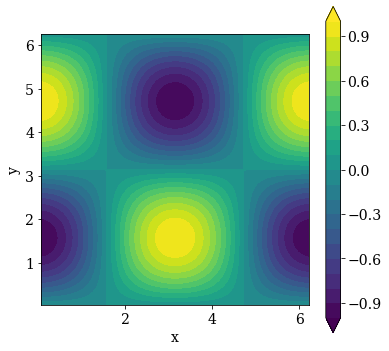

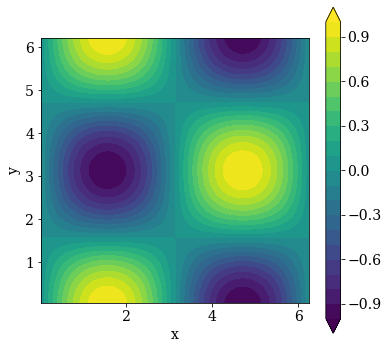

In [14]:
u = vel[:gridx.size].reshape(gridx.shape)
v = vel[gridx.size:].reshape(gridy.shape)
levels = numpy.linspace(-1.0, 1.0, num=21)
plot_contourf(gridx, u, levels=levels)
plot_contourf(gridy, v, levels=levels);

In [15]:
def assemble_operators(gridx, gridy, gridc, body,
                       dt=1.0, Re=100.0, N=1):
    """Assemble operators."""
    # Assemble the divergence operator.
    DHat = pyibm.assemble_DHat(gridc, gridx, gridy)
    # Create the Laplacian operator.
    LHat = pyibm.assemble_LHat(gridx, gridy)
    # Assemble the approximate inverse of the velocity operator.
    a_I = 0.5  # implicit coefficient from Crank-Nicolson scheme
    BN = pyibm.assemble_BN(gridx, gridy, dt=dt, alpha=a_I / Re,
                           N=N, L=LHat)
    # Create the scaling diagonal matrix MHat.
    MHat = pyibm.assemble_MHat(gridx, gridy)
    # Create the scaling diagonal matrix R.
    R = pyibm.assemble_R(gridx, gridy)
    # Assemble delta kernel operator.
    Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                              kernel=pyibm.delta_roma_et_al_1999,
                              kernel_size=2)
    # Create the interpolation operator (as implemented in PetIBM).
    EHat = Op @ R @ MHat
    # Create the speading operator (as implemented in PetIBM).
    HHat = csr_matrix(Op.T)
    # Create the LHS operator of the system for the Lagrangian forces.
    EBNH = EHat @ BN @ HHat
    return DHat, BN, EHat, HHat, EBNH

In [16]:
DHat, BN, EHat, HHat, EBNH = assemble_operators(gridx, gridy, gridc,
                                                body, N=1,
                                                dt=0.01, Re=100.0)

(0.015566859409602275, 1.2815220428177696, 82.32373718408958)

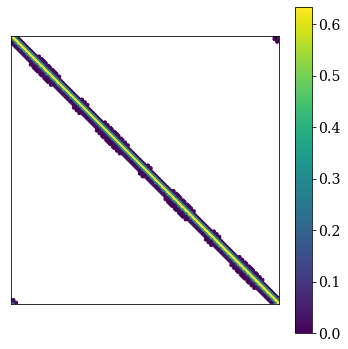

In [17]:
# Plot the non-zero structure of the operator.
pyibm.plot_matrix(EBNH, cmap='viridis', markersize=10)
pyibm.condition_number(EBNH)

In [18]:
# compute the divergence of the velocity field.
div = DHat @ vel
print_stats(div)

Mean: -1.8735013540549518e-20
Min, Max: -0.06280084934519624, 0.06280084934519624
L_inf: 0.06280084934519624
L_2: 0.888559053429476


In [19]:
# Check the divergence of the velocity is zero in sub region.
_, div_box = solution_in_box(div, gridc, box=(1.0, 5.0, 1.0, 5.0))
print_stats(div_box)

Mean: -2.391717079648373e-20
Min, Max: -1.496198998029996e-17, 1.452830911130576e-17
L_inf: 1.496198998029996e-17
L_2: 2.9280747366682954e-16


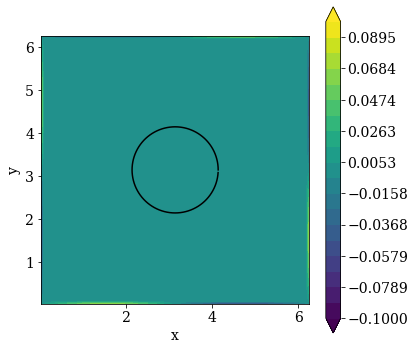

In [20]:
plot_contourf(gridc, div, body=body,
              levels=numpy.linspace(-0.1, 0.1, num=20));

In [21]:
# Assemble the right-hand side of the Lagrangian system.
rhsf = vel_B - EHat @ vel
print_stats(rhsf)

Mean: 0.0
Min, Max: -1.6819523055061993, 1.6792283414740705
L_inf: 1.6819523055061993
L_2: 12.535281923566508


In [22]:
# Solve the Lagrangian system with a direct solver.
df = splinalg.spsolve(EBNH, rhsf)
print_stats(df)

Mean: 1.7514362213422175e-06
Min, Max: -4.173414856491489, 4.8440834009987075
L_inf: 4.8440834009987075
L_2: 17.205865258299433


In [23]:
def distance_to_neighbor(body, grid):
    """Compute directional distances markers / fluid points."""
    xb, yb = body.x, body.y
    x, y = grid.x.vertices, grid.y.vertices
    dx, dy = numpy.empty(body.size), numpy.empty(body.size)
    for k, (xb_k, yb_k) in enumerate(zip(body.x, body.y)):
        i = numpy.argmin(numpy.abs(x - xb_k))
        j = numpy.argmin(numpy.abs(y - yb_k))
        dx[k], dy[k] = xb_k - x[i], yb_k - y[j]
    return dx, dy

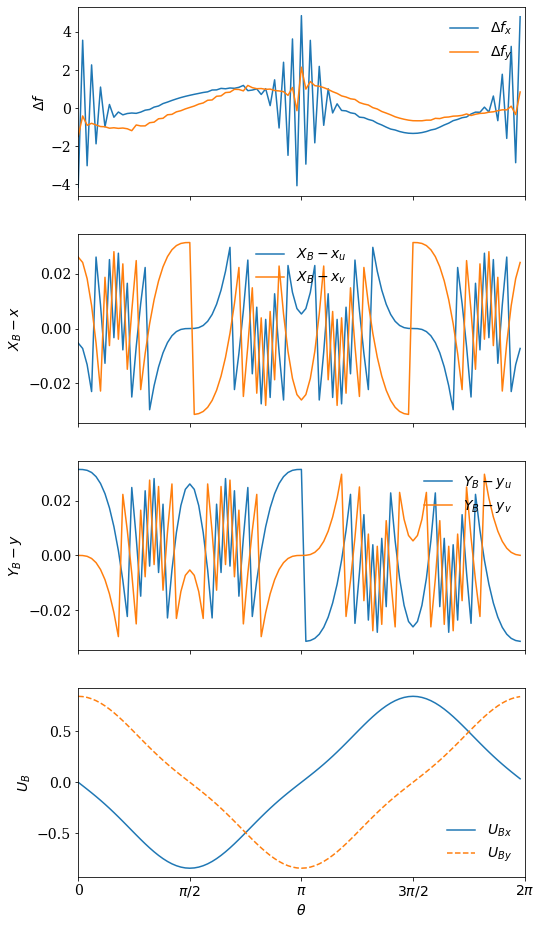

In [24]:
# Plot the magnitude of the Lagragian forces over the surface of the body.
df_x, df_y = df[::body.ndim], df[1::body.ndim]
theta = numpy.linspace(0.0, 2 * numpy.pi, num=body.size + 1)[:-1]

dx_x, dy_x = distance_to_neighbor(body, gridx)
dx_y, dy_y = distance_to_neighbor(body, gridy)

u_B, v_B = vel_B[:body.size], vel_B[body.size:]

fig, ax = pyplot.subplots(nrows=4, sharex=True, figsize=(8.0, 16.0))
ax[0].set_ylabel(r'$\Delta f$')
ax[0].plot(theta, df_x, label=r'${\Delta f}_x$', color='C0')
ax[0].plot(theta, df_y, label=r'${\Delta f}_y$', color='C1')
ax[0].legend(frameon=False)
ax[0].set_xlim(0.0, 2 * numpy.pi)

ax[1].set_ylabel('$X_B - x$')
ax[1].plot(theta, dx_x, label='$X_B - x_u$' , color='C0', linestyle='-')
ax[1].plot(theta, dx_y, label='$X_B - x_v$' , color='C1', linestyle='-')
ax[1].legend(frameon=False)

ax[2].set_ylabel('$Y_B - y$')
ax[2].plot(theta, dy_x, label='$Y_B - y_u$' , color='C0', linestyle='-')
ax[2].plot(theta, dy_y, label='$Y_B - y_v$' , color='C1', linestyle='-')
ax[2].legend(frameon=False)

ax[3].set_xlabel(r'$\theta$')
ax[3].set_ylabel('$U_B$')
ax[3].plot(theta, u_B, label='${U_B}_x$' , color='C0', linestyle='-')
ax[3].plot(theta, v_B, label='${U_B}_y$' , color='C1', linestyle='--')
ax[3].legend(frameon=False)
ax[3].set_xlim(0.0, 2 * numpy.pi)
ax[3].set_xticks([0.0, numpy.pi / 2, numpy.pi, 3 * numpy.pi / 2, 2 * numpy.pi])
ax[3].set_xticklabels(['0', r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'$2 \pi$']);

In [25]:
# Spread Lagrangian forces to the Eulerian velocity field.
vel += BN @ HHat @ df

# Check that the no-slip condition is satisfied.
print_stats(vel_B - EHat @ vel)

Mean: -1.7882246115279135e-17
Min, Max: -1.304512053934559e-15, 7.216449660063518e-16
L_inf: 1.304512053934559e-15
L_2: 2.862204533075111e-15


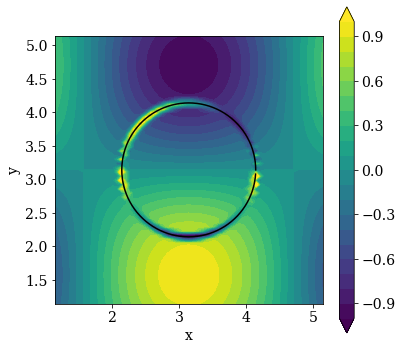

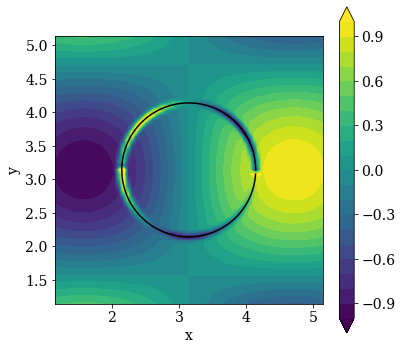

In [26]:
# Plot the filled contours of the velocity components.
u = vel[:gridx.size].reshape(gridx.shape)
v = vel[gridx.size:].reshape(gridy.shape)
axis = (center[0] - radius - 1.0, center[0] + radius + 1.0,
        center[1] - radius - 1.0, center[1] + radius + 1.0)
plot_contourf(gridx, u, levels=levels, axis=axis, body=body);
plot_contourf(gridy, v, levels=levels, axis=axis, body=body);

Mean: 0.0
Min, Max: -0.13413454543475611, 0.11274749314623886
L_inf: 0.13413454543475611
L_2: 1.0973780202321917
Mean: 0.0
Min, Max: -0.13413454543475611, 0.11274749314623886
L_inf: 0.13413454543475611
L_2: 0.6439730800718597


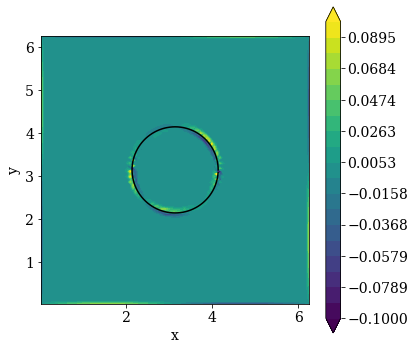

In [27]:
# Compute and plot the divergence of the velocity field.
div = DHat @ vel
print_stats(div)
_, div_box = solution_in_box(div, gridc, box=(1.0, 5.0, 1.0, 5.0))
print_stats(div_box)
plot_contourf(gridc, div, body=body,
              levels=numpy.linspace(-0.1, 0.1, num=20));

In [28]:
def analysis(ds_values, N=1, dt=0.01, Re=100.0, verbose=False):
    cond_EBNH = []
    l_inf_div = []
    for ds in ds_values:
        # Create immersed body.
        radius, center = 1.0, (numpy.pi, numpy.pi)
        body = pyibm.Body(*circle(R=radius, center=center, ds=ds),
                          grid=gridc)
        # Create initial conditions.
        vel, vel_B = get_initial_conditions(gridx, gridy, body, t, nu)
        # Assemble operators.
        D, BN, E, H, EBNH = assemble_operators(gridx, gridy, gridc, body,
                                               N=N, dt=dt, Re=Re)
        cond = pyibm.condition_number(EBNH)
        cond_EBNH.append(cond[-1])

        # Compute the RHS of the Lagrangian system.
        rhsf = vel_B - E @ vel

        # Solve the Lagrangian system.
        df = splinalg.spsolve(EBNH, rhsf)

        # Spread Lagrangian forces to the Eulerian velocity field.
        vel += BN @ H @ df

        # Compute divergence of the velocity field.
        div = D @ vel
        _, div_box = solution_in_box(div, gridc,
                                     box=(1.0, 5.0, 1.0, 5.0))
        l_inf_div.append(numpy.max(numpy.abs(div_box)))
        
        if verbose:
            print(f'\n*** ds = {ds / dx} * dx')
            print('\n EBNH:')
            print('Symmetric:', pyibm.is_symmetric(EBNH))
            print('Condition number:', cond)
            print('\n Lagrangian forces:')
            print_stats(df)
            # Check that the no-slip condition is satisfied.
            print('\n No-slip condition:')
            print_stats(vel_B - E @ vel)
            print('\n Divergence:')
            print_stats(div_box)
    
    return cond_EBNH, l_inf_div

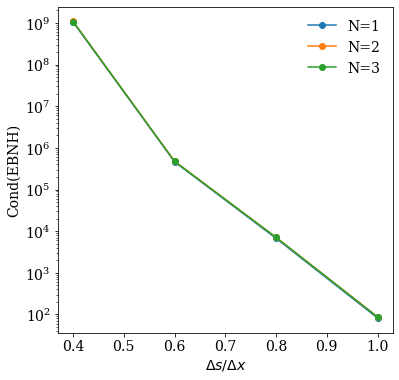

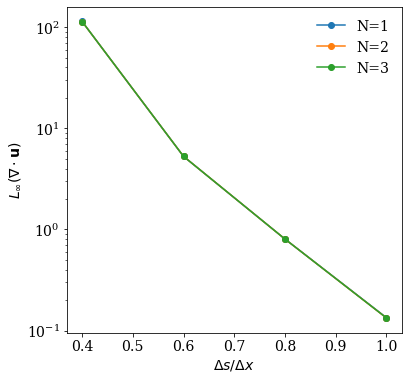

In [29]:
ds_values = numpy.array([dx, 0.8 * dx, 0.6 * dx, 0.4 * dx])
cond_EBNH1, l_inf_div1 = analysis(ds_values, N=1, dt=0.01, Re=100.0)
cond_EBNH2, l_inf_div2 = analysis(ds_values, N=2, dt=0.01, Re=100.0)
cond_EBNH3, l_inf_div3 = analysis(ds_values, N=3, dt=0.01, Re=100.0)

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel('Cond(EBNH)')
ax.semilogy(ds_values / dx, cond_EBNH1, label='N=1', marker='o')
ax.semilogy(ds_values / dx, cond_EBNH2, label='N=2', marker='o')
ax.semilogy(ds_values / dx, cond_EBNH3, label='N=3', marker='o')
ax.legend(frameon=False);

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel(r'$L_\infty (\nabla \cdot \mathbf{u})$')
ax.semilogy(ds_values / dx, l_inf_div1, label='N=1', marker='o')
ax.semilogy(ds_values / dx, l_inf_div2, label='N=2', marker='o')
ax.semilogy(ds_values / dx, l_inf_div3, label='N=3', marker='o')
ax.legend(frameon=False);

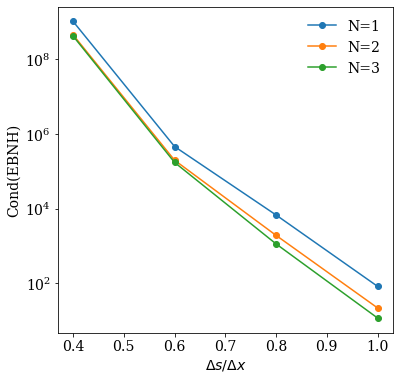

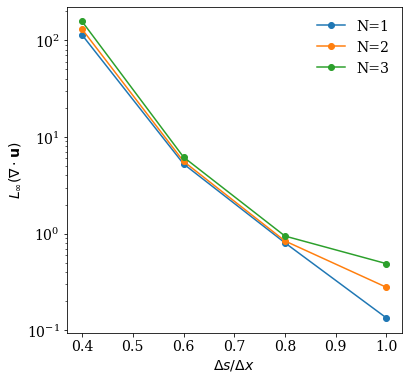

In [30]:
ds_values = numpy.array([dx, 0.8 * dx, 0.6 * dx, 0.4 * dx])
cond_EBNH1, l_inf_div1 = analysis(ds_values, N=1, dt=1.0, Re=1.0)
cond_EBNH2, l_inf_div2 = analysis(ds_values, N=2, dt=1.0, Re=1.0)
cond_EBNH3, l_inf_div3 = analysis(ds_values, N=3, dt=1.0, Re=1.0)

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel('Cond(EBNH)')
ax.semilogy(ds_values / dx, cond_EBNH1, label='N=1', marker='o')
ax.semilogy(ds_values / dx, cond_EBNH2, label='N=2', marker='o')
ax.semilogy(ds_values / dx, cond_EBNH3, label='N=3', marker='o')
ax.legend(frameon=False);

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel(r'$L_\infty (\nabla \cdot \mathbf{u})$')
ax.semilogy(ds_values / dx, l_inf_div1, label='N=1', marker='o')
ax.semilogy(ds_values / dx, l_inf_div2, label='N=2', marker='o')
ax.semilogy(ds_values / dx, l_inf_div3, label='N=3', marker='o')
ax.legend(frameon=False);